In [11]:
import os
import glob
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import torch 
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
import joblib

In [3]:
train_features = "data/train_features"
train_labels = "data/train_labels"
test_features = "data/test_features"
test_labels = "data/test_labels"

train_chips = sorted([d for d in os.listdir(train_features) if os.path.isdir(os.path.join(train_features, d))])
test_chips = sorted([d for d in os.listdir(test_features) if os.path.isdir(os.path.join(test_features, d))])

print("Total train chips ", len(train_chips))
print("Total test chips ", len(test_chips))

print("Example chip: ", train_chips[0])

Total train chips  1000
Total test chips  200
Example chip:  aeig


In [4]:
def load_chip(chip_id):
    chip_path = os.path.join(train_features, chip_id)
    band_files = sorted(glob.glob(f"{chip_path}/*.tif"))
    
    bands = []
    for f in band_files:
        with rasterio.open(f) as src:
            bands.append(src.read(1).astype(np.float32))
    img = np.stack(bands, axis=0)
    
    label_path = os.path.join(train_labels, chip_id + ".tif")
    with rasterio.open(label_path) as src:
        mask = src.read(1).astype(np.uint8)
    
    if img.max() > 1.5:
        img /= 10000.0
    
    return img, mask

In [5]:
chip_id = train_chips[0]
print(chip_id)
img, mask = load_chip(chip_id)

aeig


In [ ]:
print("Image shape ", img.shape)
print("Mask shape ", mask.shape)


Image shape  (4, 512, 512)
Mask shape  (512, 512)


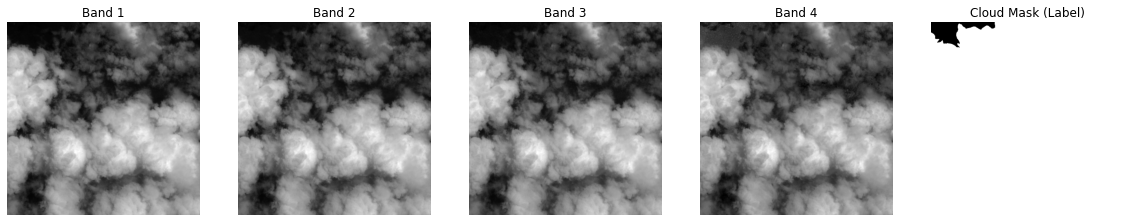

In [9]:
# Load one chip
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(4):
    axes[i].imshow(img[i], cmap='gray')
    axes[i].set_title(f"Band {i+1}")
    axes[i].axis("off")

axes[4].imshow(mask, cmap='gray')
axes[4].set_title("Cloud Mask (Label)")
axes[4].axis("off")

plt.show()

# Model Implementation

In [ ]:
class CloudDataset(Dataset):
    def __init__(self, chip_ids, features_folder, labels_folder, transform=None):
        self.chip_ids = chip_ids
        self.features_folder = features_folder
        self.labels_folder = labels_folder
        self.transform = transform

    def __len__(self):
        return len(self.chip_ids)

    def __getitem__(self, idx):

        chip_id = self.chip_ids[idx]
        chip_path = os.path.join(self.features_folder, chip_id)
        label_path = os.path.join(self.labels_folder, chip_id + ".tif")

        desired_bands = ['B02.tif', 'B03.tif', 'B04.tif', 'B08.tif']

        bands = []
        for band_name in desired_bands:
            band_file = os.path.join(chip_path, band_name)
            with rasterio.open(band_file) as src:
                bands.append(src.read(1).astype(np.float32))
        img = np.stack(bands, axis=0)

        with rasterio.open(label_path) as src:
            mask = src.read(1).astype(np.uint8)

        if img.max() > 1.5:
            img /= 10000.0

        img = torch.tensor(img, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)

        return img, mask

In [25]:
train_dataset = CloudDataset(train_chips, train_features, train_labels)
val_dataset = CloudDataset(test_chips, test_features, test_labels)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [26]:
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

Using device: mps


In [27]:
model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=4,
    classes=2
)

model = model.to(DEVICE)

In [19]:
loss_fn = smp.losses.DiceLoss(mode='multiclass')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [20]:
def iou_score(preds, masks, num_classes=2):
    ious = []
    preds = preds.view(-1)
    masks = masks.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = masks == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            ious.append(float("nan"))
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)

In [21]:
def train_one_epoch(loader, model, optimizer, loss_fn):
    model.train()
    epoch_loss = 0
    epoch_iou = 0

    for imgs, masks in loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)

        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        epoch_iou += iou_score(preds.cpu(), masks.cpu())

    return epoch_loss / len(loader), epoch_iou / len(loader)

In [22]:
def validate(loader, model, loss_fn):

    model.eval()
    epoch_loss = 0
    epoch_iou = 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            outputs = model(imgs)

            loss = loss_fn(outputs, masks)
            epoch_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            epoch_iou += iou_score(preds.cpu(), masks.cpu())

    return epoch_loss / len(loader), epoch_iou / len(loader)

In [28]:
for epoch in range(5):
    train_loss, train_iou = train_one_epoch(train_loader, model, optimizer, loss_fn)
    val_loss, val_iou = validate(val_loader, model, loss_fn)

    print(f"Epoch {epoch+1} | "
          f"Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f} | "
          f"Val Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")

Epoch 1 | Train Loss: 0.0192, IoU: 0.2944 | Val Loss: 0.0433, IoU: 0.2739
Epoch 2 | Train Loss: 0.0228, IoU: 0.2957 | Val Loss: 0.0405, IoU: 0.2856
Epoch 3 | Train Loss: 0.0278, IoU: 0.2943 | Val Loss: 0.0454, IoU: 0.2681
Epoch 4 | Train Loss: 0.0197, IoU: 0.2947 | Val Loss: 0.0409, IoU: 0.2824
Epoch 5 | Train Loss: 0.0375, IoU: 0.2950 | Val Loss: 0.0412, IoU: 0.2763


In [64]:
def show_predictions(model, dataloader, num_examples=3):
    model.eval()
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(dataloader):
            if i >= num_examples:
                break
            outputs = model(imgs.to(DEVICE))
            preds = torch.argmax(outputs, dim=1)

            fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=120)
            ax[0].imshow(imgs[0][0], cmap='gray')
            ax[0].set_title('Input Image')
            ax[1].imshow(masks[0], cmap='gray')
            ax[1].set_title('Ground Truth')
            ax[2].imshow(preds[0].cpu(), cmap='gray', interpolation='nearest')
            ax[2].set_title('Prediction')
            plt.show()

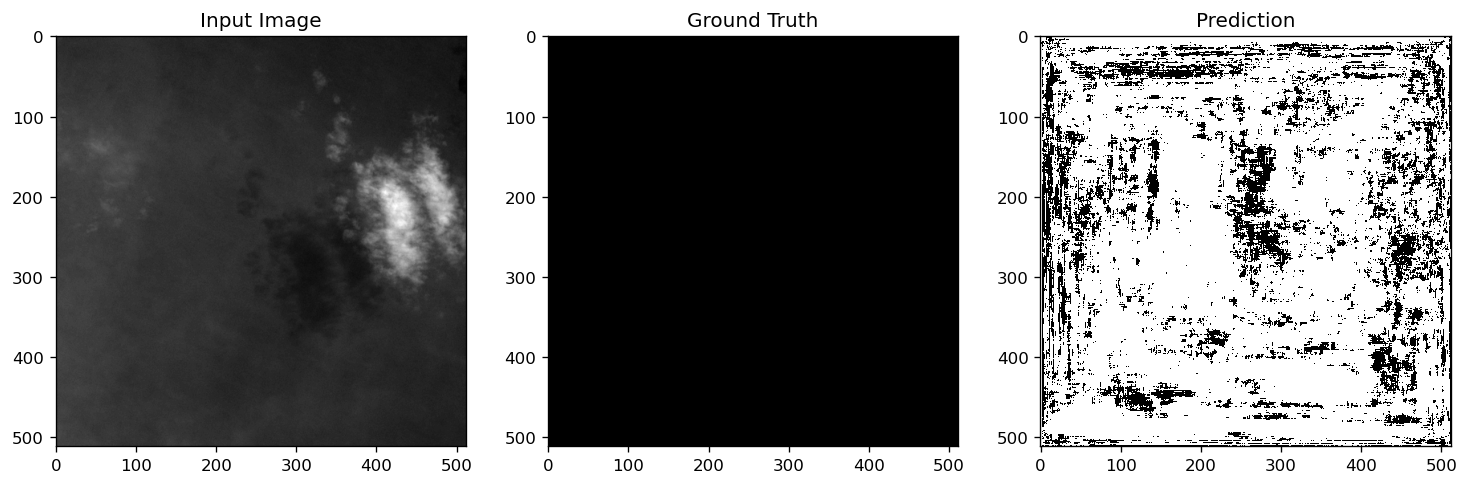

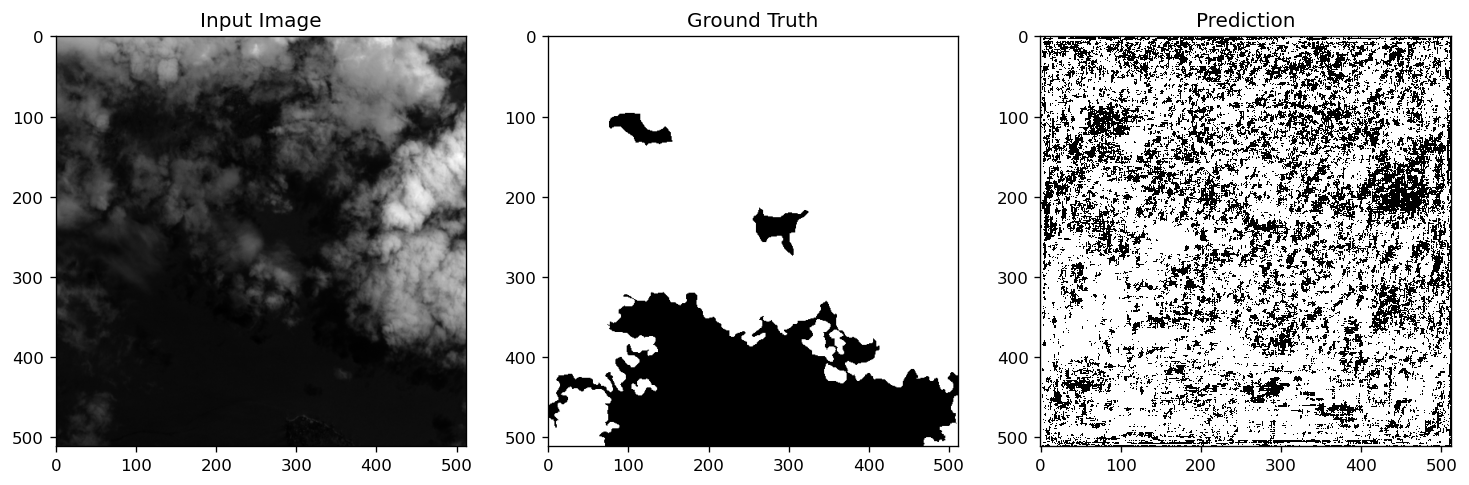

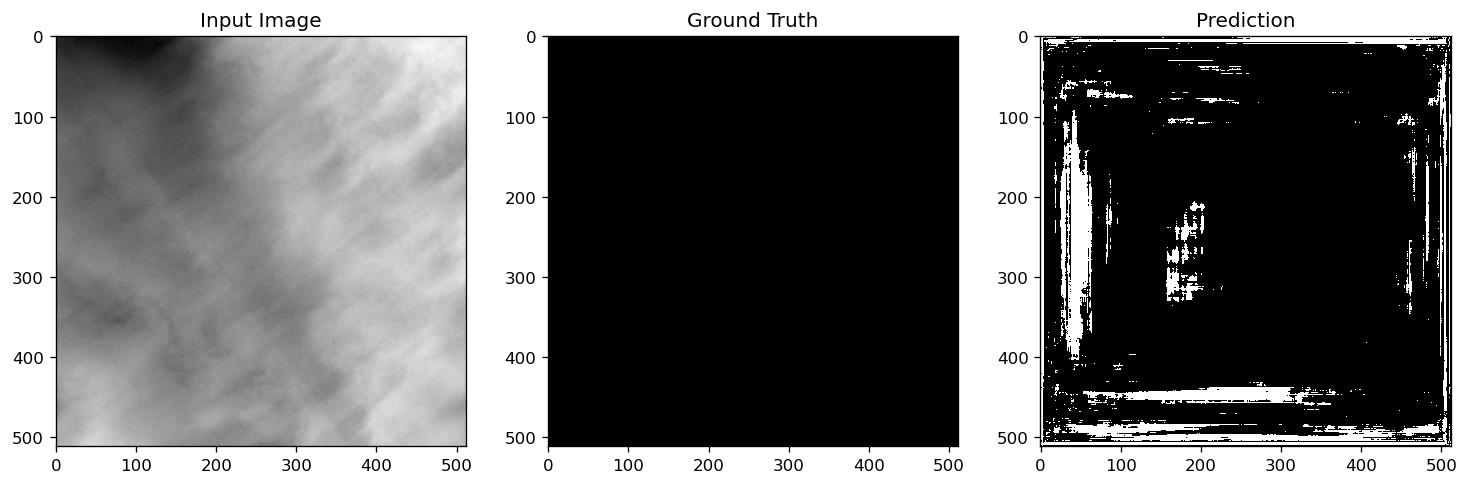

In [65]:
show_predictions(model, val_loader, num_examples=3)

In [68]:
joblib.dump(model.cpu(), './models/cloud_detector.pkl')

['./models/cloud_detector.pkl']